In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [10]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [11]:
# max_component_num = 100
# max_bezier_curve_num = 1000

# image_floder = 'CS 3570 Final Project Topic5'

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100)

In [12]:
import numpy as np
from scipy.linalg import lstsq
from scipy.spatial import distance

def compute_arc_length_params(points):
    """
    計算弧長參數化的參數 t_i
    :param points: 样本点列表 [(x0, y0), (x1, y1), ..., (xn, yn)]
    :return: 弧长参数化后的参数列表 [t0, t1, ..., tn]
    """
    n = len(points)
    dists = [np.linalg.norm(np.array(points[i]) - np.array(points[i-1])) for i in range(1, n)]
    s = [0] + np.cumsum(dists).tolist()
    total_length = s[-1]
    t = [si / total_length for si in s]
    return t

def fit_bezier_curve(points):
    """
    拟合三次贝塞尔曲线
    :param points: 样本点列表 [(x0, y0), (x1, y1), ..., (xn, yn)]
    :return: 控制点 [(P0x, P0y), (P1x, P1y), (P2x, P2y), (P3x, P3y)]
    """
    points = np.array(points)
    t = compute_arc_length_params(points)
    
    # 设定 P0 和 P3
    P0 = points[0]
    P3 = points[-1]
    
    # 构建矩阵 A 和向量 B
    A = []
    Bx = []
    By = []
    
    for i in range(1, len(points) - 1):
        ti = t[i]
        A.append([3 * (1 - ti)**2 * ti, 3 * (1 - ti) * ti**2])
        Bx.append(points[i, 0] - ((1 - ti)**3 * P0[0] + ti**3 * P3[0]))
        By.append(points[i, 1] - ((1 - ti)**3 * P0[1] + ti**3 * P3[1]))
    
    A = np.array(A)
    Bx = np.array(Bx)
    By = np.array(By)
    
    # 解最小二乘问题
    Px, _, _, _ = lstsq(A, Bx)
    Py, _, _, _ = lstsq(A, By)
    
    P1 = (Px[0], Py[0])
    P2 = (Px[1], Py[1])
    
    return [tuple(P0), P1, P2, tuple(P3)],t

def bezier_curve(t, p0, p1, p2, p3):
    """
    计算贝塞尔曲线上的点
    :param t: 参数t（0到1之间）
    :param p0: 控制点P0
    :param p1: 控制点P1
    :param p2: 控制点P2
    :param p3: 控制点P3
    :return: 贝塞尔曲线上的点
    """
    return (1-t)**3 * p0 + 3*(1-t)**2 * t * p1 + 3*(1-t) * t**2 * p2 + t**3 * p3

def compute_approximation_error(points, control_points, points_t,important_mask,V22):
    if V22:
        """
        计算逼近误差
        依據面積計算
        """
        error_area=np.zeros(important_mask.shape)
        curve_points = []
        
        # 遍历样本点
        for t in points_t:
            curve_point = bezier_curve(t, *control_points)
            curve_points.append(curve_point)
        curve_points.reverse()
        curve_points = np.array(curve_points)
        poly_points = np.concatenate([points,curve_points],0).astype(np.int32)
        cv2.fillPoly(error_area,[poly_points],(1))
        error_area=important_mask*error_area
        # plt.imshow(error_area)
        # plt.show()
        total_error=np.sum(error_area)
        
        return total_error
    else:
        """
        计算逼近误差
        :param points: 样本点列表 [(x0, y0), (x1, y1), ..., (xn, yn)]
        :param control_points: 控制点列表 [(P0x, P0y), (P1x, P1y), (P2x, P2y), (P3x, P3y)]
        :return: 逼近误差
        """
        total_error = 0
        n = len(points)
        
        # 遍历样本点
        for point, t in zip(points,points_t):
            curve_point = bezier_curve(t, *control_points)
            dist = distance.euclidean(point, curve_point)
            total_error +=dist
        
        return total_error

def fit_bezier_curve_and_error(points,important_mask,V22):
    control_points,points_t = fit_bezier_curve(points)
    loss=compute_approximation_error(points,np.array(control_points),points_t,important_mask,V22)
    return control_points,loss

def mask_to_contours(mask,V21):
    mask = mask.astype(np.uint8)*255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_points = []
    filled_masks_area = []
    filled_masks = []
    for contour in contours:
        filled_mask = np.zeros(mask.shape, dtype=np.uint8)
        cv2.drawContours(filled_mask, [contour], -1, (1), thickness=cv2.FILLED)
        filled_masks.append(filled_mask)
        filled_masks_area.append(np.sum(filled_mask))
        if V21:
            contours_points.append(np.concatenate([contour[:, 0, :],contour[:1, 0, :]],0)+0.5)
        else:
            contours_points.append(np.concatenate([contour[:, 0, :],contour[:1, 0, :]],0))
    return contours_points,filled_masks,filled_masks_area

def split_bezier_curve(ma,mt,max_loss_control_points_set,V22):
    control_points_set_1 = dict()
    t1=max_loss_control_points_set["range"][0]
    t2=mt
    control_points,loss=fit_bezier_curve_and_error(ma["contours_points"][t1:t2],ma["important_mask"],V22)
    control_points_set_1["control_points"]=control_points
    control_points_set_1["loss"]=loss
    control_points_set_1["range"]=[t1,t2]
    control_points_set_2 = dict()
    t1=mt
    t2=max_loss_control_points_set["range"][1]
    control_points,loss=fit_bezier_curve_and_error(ma["contours_points"][t1:t2],ma["important_mask"],V22)
    control_points_set_2["control_points"]=control_points
    control_points_set_2["loss"]=loss
    control_points_set_2["range"]=[t1,t2]
    return control_points_set_1,control_points_set_2,control_points_set_1["loss"]+control_points_set_2["loss"]

In [13]:
def write_svg(filename,sorted_masks,scale,V21):
    with open(filename, 'w') as f:
        f.write('<svg xmlns="http://www.w3.org/2000/svg" width="'+str(scale[3])+'" height="'+str(scale[2])+'" viewbox="0 0 '+str(scale[3])+' '+str(scale[2])+'">\n')
        for ma in sorted_masks:
            control_points_sets = ma["control_points_sets"]
            rgb = ma["color"]
            control_points = control_points_sets[0]["control_points"]
            f.write('<path d="M {:.2f} {:.2f} '.format(control_points[0][0]*scale[1], control_points[0][1]*scale[0]))
            for control_points_set in control_points_sets:
                control_points = control_points_set["control_points"]
                f.write('C {:.2f} {:.2f}, {:.2f} {:.2f}, {:.2f} {:.2f} '.format(control_points[1][0]*scale[1], control_points[1][1]*scale[0],control_points[2][0]*scale[1], control_points[2][1]*scale[0], control_points[3][0]*scale[1],control_points[3][1]*scale[0]))
            if V21:
                f.write('Z" fill="rgb('+str(rgb[0])+','+str(rgb[1])+','+str(rgb[2])+')" />\n')
            else:
                f.write('Z" fill="rgb('+str(rgb[0])+','+str(rgb[1])+','+str(rgb[2])+')" stroke="rgb('+str(rgb[0])+','+str(rgb[1])+','+str(rgb[2])+')" stroke-width="1" />\n')
        f.write('</svg>')

In [14]:
def SAMVGV1(image_path,max_component_num,max_bezier_curve_num,V21=True,V22=False,V23=False,V31=True,V32=False,Vis=100000):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    scale = [1,1,image.shape[0],image.shape[1]]
    if image.shape[0]*image.shape[1]>1024*1024:
        scale = [image.shape[0]/1024,image.shape[1]/1024,image.shape[0],image.shape[1]]
        image = cv2.resize(image, (1024, 1024))
    masks = mask_generator.generate(image)
    m=np.ones(image.shape[0:2])
    # 找輪廓
    contours_points,filled_masks,filled_masks_area=mask_to_contours(m,V21)
    ma = dict()
    ma["contours_points"] = contours_points[0]
    ma["filled_mask"] = filled_masks[0]
    ma["filled_mask_area"] = filled_masks_area[0]
    new_masks=[ma]
    for i in range(len(masks)):
        m = masks[i]['segmentation']
        contours_points,filled_masks,filled_masks_area=mask_to_contours(m,V21)
        for i in range(len(contours_points)):
            ma = dict()
            ma["contours_points"] = contours_points[i]
            ma["filled_mask"] = filled_masks[i]
            ma["filled_mask_area"] = filled_masks_area[i]
            if len(ma["contours_points"])>=4:
                new_masks.append(ma)
    sorted_masks = sorted(new_masks, key=(lambda x: x['filled_mask_area']), reverse=True)[:max_component_num]
    sorted_masks.reverse()

    # important_mask
    important_mask = np.ones(sorted_masks[0]["filled_mask"].shape)
    for i,ma in enumerate(sorted_masks):
        sorted_masks[i]["important_mask"] = important_mask.copy()
        important_mask = important_mask*(1-sorted_masks[i]["filled_mask"])
        # plt.imshow(important_mask)
        # plt.show()
    
    # 優化bezier_curve，初始化，每人一條
    use_bezier_curve_num = 0
    for ma in sorted_masks:
        control_points,loss=fit_bezier_curve_and_error(ma["contours_points"],ma["important_mask"],V22)
        control_points_set = dict()
        control_points_set["control_points"]=control_points
        control_points_set["loss"]=loss
        control_points_set["range"]=[0,len(ma["contours_points"])-1]
        ma["control_points_sets"]=[control_points_set]
        use_bezier_curve_num+=1
        if use_bezier_curve_num>=max_bezier_curve_num:
            break
    if V32:
        # 基於curve重算fillmask
        for i1,ma in enumerate(sorted_masks):
            bezier_curve_conuter = []
            for i2,control_points_set in enumerate(ma["control_points_sets"]):
                curve_sample_num=control_points_set["range"][1]-control_points_set["range"][0]+1
                ts=np.linspace(0, 1, curve_sample_num)
                for t in ts:
                    curve_point = bezier_curve(t, *np.array(control_points_set["control_points"]))
                    bezier_curve_conuter.append(curve_point)
            bezier_curve_conuter = np.array(bezier_curve_conuter).astype(np.int32)
            bezier_curve_area = np.zeros(sorted_masks[0]["filled_mask"].shape)
            sorted_masks[i1]["filled_mask"] = cv2.fillPoly(bezier_curve_area,[bezier_curve_conuter],(1))

    if V32:
        # 重算important_mask
        important_mask = np.ones(sorted_masks[0]["filled_mask"].shape)
        for i,ma in enumerate(sorted_masks):
            sorted_masks[i]["important_mask"] = important_mask.copy()
            important_mask = important_mask*(1-sorted_masks[i]["filled_mask"])
            # plt.imshow(important_mask)
            # plt.show()

    # 優化bezier_curve
    while use_bezier_curve_num<max_bezier_curve_num:
        use_bezier_curve_num+=1
        max_loss_control_points_set = sorted_masks[0]["control_points_sets"][0]
        max_loss_ma_index = 0
        max_loss_ma_control_points_sets_index = 0
        for i1,ma in enumerate(sorted_masks):
            for i2,control_points_set in enumerate(ma["control_points_sets"]):
                if control_points_set["loss"]>max_loss_control_points_set["loss"]:
                    max_loss_control_points_set = control_points_set
                    max_loss_ma_index = i1
                    max_loss_ma_control_points_sets_index = i2
        if max_loss_control_points_set["range"][1]-max_loss_control_points_set["range"][0]<8:
            break
        ma = sorted_masks[max_loss_ma_index]
        sorted_masks[max_loss_ma_index]["control_points_sets"].pop(max_loss_ma_control_points_sets_index)
        #2log search
        tmin = max_loss_control_points_set["range"][0]+4
        tmax = max_loss_control_points_set["range"][1]-4
        tmid=int((tmin+tmax)//2)
        trange = int((tmax-tmin)//4)
        control_points_set_1,control_points_set_2,mtloss=split_bezier_curve(ma,tmid,max_loss_control_points_set,V22)
        if V23:
            while trange>=1:
                Lcontrol_points_set_1,Lcontrol_points_set_2,Lmtloss=split_bezier_curve(ma,tmid-trange,max_loss_control_points_set,V22)
                Rcontrol_points_set_1,Rcontrol_points_set_2,Rmtloss=split_bezier_curve(ma,tmid+trange,max_loss_control_points_set,V22)
                if Lmtloss<mtloss:
                    control_points_set_1 = Lcontrol_points_set_1
                    control_points_set_2 = Lcontrol_points_set_2
                    mtloss = Lmtloss
                    tmid = tmid-trange
                if Rmtloss<mtloss:
                    control_points_set_1 = Rcontrol_points_set_1
                    control_points_set_2 = Rcontrol_points_set_2
                    mtloss = Rmtloss
                    tmid = tmid+trange
                trange = int(trange//2)

        ma["control_points_sets"].insert(max_loss_ma_control_points_sets_index,control_points_set_1)
        ma["control_points_sets"].insert(max_loss_ma_control_points_sets_index+1,control_points_set_2)
        if V32:
            #重算filled_mask
            bezier_curve_conuter = []
            for i2,control_points_set in enumerate(ma["control_points_sets"]):
                curve_sample_num=control_points_set["range"][1]-control_points_set["range"][0]+1
                ts=np.linspace(0, 1, curve_sample_num)
                for t in ts:
                    curve_point = bezier_curve(t, *np.array(control_points_set["control_points"]))
                    bezier_curve_conuter.append(curve_point)
            bezier_curve_conuter = np.array(bezier_curve_conuter).astype(np.int32)
            bezier_curve_area = np.zeros(sorted_masks[0]["filled_mask"].shape)
            sorted_masks[max_loss_ma_index]["filled_mask"] = cv2.fillPoly(bezier_curve_area,[bezier_curve_conuter],(1))
        
        if V32:
            # 重算important_mask
            important_mask = np.ones(sorted_masks[0]["filled_mask"].shape)
            for i,ma in enumerate(sorted_masks):
                sorted_masks[i]["important_mask"] = important_mask.copy()
                important_mask = important_mask*(1-sorted_masks[i]["filled_mask"])
                # plt.imshow(important_mask)
                # plt.show()
        
        if use_bezier_curve_num%Vis==0:
            if V31:
                #重算filled_mask
                bezier_curve_conuter = []
                for i2,control_points_set in enumerate(ma["control_points_sets"]):
                    curve_sample_num=control_points_set["range"][1]-control_points_set["range"][0]+1
                    ts=np.linspace(0, 1, curve_sample_num)
                    for t in ts:
                        curve_point = bezier_curve(t, *np.array(control_points_set["control_points"]))
                        bezier_curve_conuter.append(curve_point)
                bezier_curve_conuter = np.array(bezier_curve_conuter).astype(np.int32)
                bezier_curve_area = np.zeros(sorted_masks[0]["filled_mask"].shape)
                sorted_masks[max_loss_ma_index]["filled_mask"] = cv2.fillPoly(bezier_curve_area,[bezier_curve_conuter],(1))
            
            # 決定顏色
            for i1,ma in enumerate(sorted_masks):
                bezier_curve_conuter = []
                for i2,control_points_set in enumerate(ma["control_points_sets"]):
                    curve_sample_num=control_points_set["range"][1]-control_points_set["range"][0]+1
                    ts=np.linspace(0, 1, curve_sample_num)
                    for t in ts:
                        curve_point = bezier_curve(t, *np.array(control_points_set["control_points"]))
                        bezier_curve_conuter.append(curve_point)
                bezier_curve_conuter = np.array(bezier_curve_conuter).astype(np.int32)
                bezier_curve_area = np.zeros(sorted_masks[0]["filled_mask"].shape)
                sorted_masks[i1]["filled_mask"] = cv2.fillPoly(bezier_curve_area,[bezier_curve_conuter],(1))
            
            image_color_mask = np.ones(sorted_masks[0]["filled_mask"].shape)
            for i,ma in enumerate(sorted_masks):
                tm = image_color_mask*ma["filled_mask"]
                sorted_masks[i]["color"] = np.sum(image * np.expand_dims(tm,2),(0,1))/np.sum(tm)
                image_color_mask = image_color_mask * (1-ma["filled_mask"])
            sorted_masks.reverse()
            write_svg('SVG_'+image_path.split('.')[0]+'-'+str(use_bezier_curve_num)+'.svg', sorted_masks,scale,V21)
        
    print(image_path,"\nuse_bezier_curve_num :",use_bezier_curve_num,"\ncomponent_num :",len(sorted_masks))
    if V31:
        #重算filled_mask
        bezier_curve_conuter = []
        for i2,control_points_set in enumerate(ma["control_points_sets"]):
            curve_sample_num=control_points_set["range"][1]-control_points_set["range"][0]+1
            ts=np.linspace(0, 1, curve_sample_num)
            for t in ts:
                curve_point = bezier_curve(t, *np.array(control_points_set["control_points"]))
                bezier_curve_conuter.append(curve_point)
        bezier_curve_conuter = np.array(bezier_curve_conuter).astype(np.int32)
        bezier_curve_area = np.zeros(sorted_masks[0]["filled_mask"].shape)
        sorted_masks[max_loss_ma_index]["filled_mask"] = cv2.fillPoly(bezier_curve_area,[bezier_curve_conuter],(1))
    
    # 決定顏色
    for i1,ma in enumerate(sorted_masks):
        bezier_curve_conuter = []
        for i2,control_points_set in enumerate(ma["control_points_sets"]):
            curve_sample_num=control_points_set["range"][1]-control_points_set["range"][0]+1
            ts=np.linspace(0, 1, curve_sample_num)
            for t in ts:
                curve_point = bezier_curve(t, *np.array(control_points_set["control_points"]))
                bezier_curve_conuter.append(curve_point)
        bezier_curve_conuter = np.array(bezier_curve_conuter).astype(np.int32)
        bezier_curve_area = np.zeros(sorted_masks[0]["filled_mask"].shape)
        sorted_masks[i1]["filled_mask"] = cv2.fillPoly(bezier_curve_area,[bezier_curve_conuter],(1))
    
    image_color_mask = np.ones(sorted_masks[0]["filled_mask"].shape)
    for i,ma in enumerate(sorted_masks):
        tm = image_color_mask*ma["filled_mask"]
        sorted_masks[i]["color"] = np.sum(image * np.expand_dims(tm,2),(0,1))/np.sum(tm)
        image_color_mask = image_color_mask * (1-ma["filled_mask"])
    sorted_masks.reverse()
    write_svg('SVG_'+image_path.split('.')[0]+'.svg', sorted_masks,scale,V21)

In [15]:
#evaluation
def calculate_mse(image1, image2):
    image1 = cv2.imread(image1)
    image2 = cv2.imread(image2)
    # Ensure images are the same shape
    if image1.size != image2.size:
        raise ValueError("Images must have the same dimensions for MSE calculation")
    


    
    # Compute MSE
    mse = np.mean((image1 - image2) ** 2)
    return mse


128\emoji_u1f3c4_1f3ff_200d_2640.png 
use_bezier_curve_num : 200 
component_num : 20


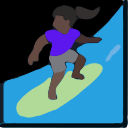

128\emoji_u1f3c4_1f3ff_200d_2640.png vs SVG2PNG_128\emoji_u1f3c4_1f3ff_200d_2640.png: 67.71809895833333
128\emoji_u1f3e7.png 
use_bezier_curve_num : 166 
component_num : 14


C:\Users\a5658\AppData\Local\Temp\ipykernel_19356\2924573033.py:200: RuntimeWarning: invalid value encountered in divide
  sorted_masks[i]["color"] = np.sum(image * np.expand_dims(tm,2),(0,1))/np.sum(tm)


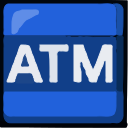

128\emoji_u1f3e7.png vs SVG2PNG_128\emoji_u1f3e7.png: 44.084737141927086
128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png 
use_bezier_curve_num : 200 
component_num : 20


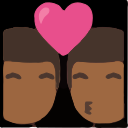

128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png vs SVG2PNG_128\emoji_u1f468_1f3fe_200d_2764_200d_1f48b_200d_1f468_1f3fe.png: 43.523457845052086
128\emoji_u1f469_1f3fc_200d_1f3eb.png 
use_bezier_curve_num : 200 
component_num : 20


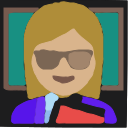

128\emoji_u1f469_1f3fc_200d_1f3eb.png vs SVG2PNG_128\emoji_u1f469_1f3fc_200d_1f3eb.png: 78.57383219401042
128\emoji_u1f481_1f3fc_200d_2642.png 
use_bezier_curve_num : 200 
component_num : 20


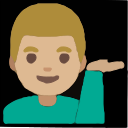

128\emoji_u1f481_1f3fc_200d_2642.png vs SVG2PNG_128\emoji_u1f481_1f3fc_200d_2642.png: 31.587727864583332
128\emoji_u1f4b5.png 
use_bezier_curve_num : 177 
component_num : 14


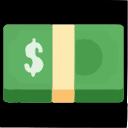

128\emoji_u1f4b5.png vs SVG2PNG_128\emoji_u1f4b5.png: 34.621073404947914
128\emoji_u1f58a.png 
use_bezier_curve_num : 127 
component_num : 16


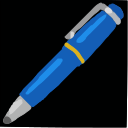

128\emoji_u1f58a.png vs SVG2PNG_128\emoji_u1f58a.png: 18.830159505208332
128\emoji_u1f645_1f3fc.png 
use_bezier_curve_num : 200 
component_num : 20


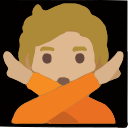

128\emoji_u1f645_1f3fc.png vs SVG2PNG_128\emoji_u1f645_1f3fc.png: 31.02349853515625
128\emoji_u1f645_1f3ff_200d_2642.png 
use_bezier_curve_num : 200 
component_num : 20


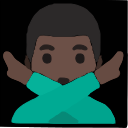

128\emoji_u1f645_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f645_1f3ff_200d_2642.png: 31.494710286458332
128\emoji_u1f64e_1f3ff_200d_2642.png 
use_bezier_curve_num : 200 
component_num : 20


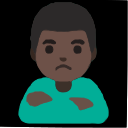

128\emoji_u1f64e_1f3ff_200d_2642.png vs SVG2PNG_128\emoji_u1f64e_1f3ff_200d_2642.png: 22.59967041015625
128\emoji_u1f6b6_200d_2642_200d_27a1.png 
use_bezier_curve_num : 187 
component_num : 19


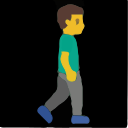

128\emoji_u1f6b6_200d_2642_200d_27a1.png vs SVG2PNG_128\emoji_u1f6b6_200d_2642_200d_27a1.png: 10.578877766927084
128\emoji_u1f6cc_1f3fb.png 
use_bezier_curve_num : 200 
component_num : 20


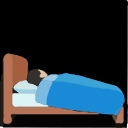

128\emoji_u1f6cc_1f3fb.png vs SVG2PNG_128\emoji_u1f6cc_1f3fb.png: 17.412882486979168
128\emoji_u1f9d5_1f3fd.png 
use_bezier_curve_num : 170 
component_num : 15


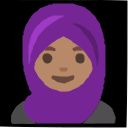

128\emoji_u1f9d5_1f3fd.png vs SVG2PNG_128\emoji_u1f9d5_1f3fd.png: 33.217081705729164
128\emoji_u1f9d9_1f3fc_200d_2640.png 
use_bezier_curve_num : 200 
component_num : 20


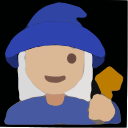

128\emoji_u1f9d9_1f3fc_200d_2640.png vs SVG2PNG_128\emoji_u1f9d9_1f3fc_200d_2640.png: 43.652811686197914
128\emoji_u1f9ea.png 
use_bezier_curve_num : 187 
component_num : 18


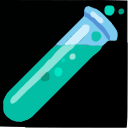

128\emoji_u1f9ea.png vs SVG2PNG_128\emoji_u1f9ea.png: 12.633056640625
128 Total MSE: 521.5516764322917


In [16]:
max_component_num = 20
max_bezier_curve_num = 200

image_floder = '128'

import os

gtkbin = r'C:\Program Files\GTK3-Runtime Win64\bin'
add_dll_dir = getattr(os, 'add_dll_directory', None)
if callable(add_dll_dir):
    add_dll_dir(gtkbin)
else:
    os.environ['PATH'] = os.pathsep.join((gtkbin, os.environ['PATH']))

import glob
import random
from cairosvg import svg2png
from IPython.display import display, SVG


image_paths=glob.glob(image_floder+"/*.jpg")+glob.glob(image_floder+"/*.png")
# random.shuffle(image_paths)
tmse=0

for image_path in image_paths:
    SAMVGV1(image_path,max_component_num,max_bezier_curve_num,V21=False,V31=False)

    #convert SVG to PNG
    svg_path = 'SVG_' + image_path.split('.')[0]+'.svg'
    write_path = 'SVG2PNG_' + image_path.split('.')[0] + '.png'
    # Display an SVG file directly from its path
    display(SVG(filename=svg_path))
    svg2png(url=svg_path, write_to=write_path, unsafe=True)
    mse=calculate_mse(image_path, write_path)
    tmse+=mse
    print(image_path +" vs " + write_path + ": " + str(mse))
print(image_floder+" Total MSE:",tmse)



Topic5\fallingwater.jpg 
use_bezier_curve_num : 1000 
component_num : 100


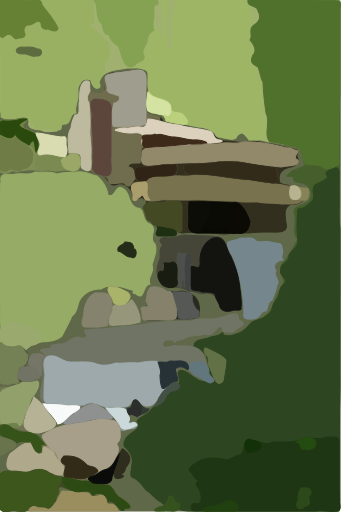

Topic5\fallingwater.jpg vs SVG2PNG_Topic5\fallingwater.png: 97.75958997739491
Topic5\flower.jpg 
use_bezier_curve_num : 1000 
component_num : 100


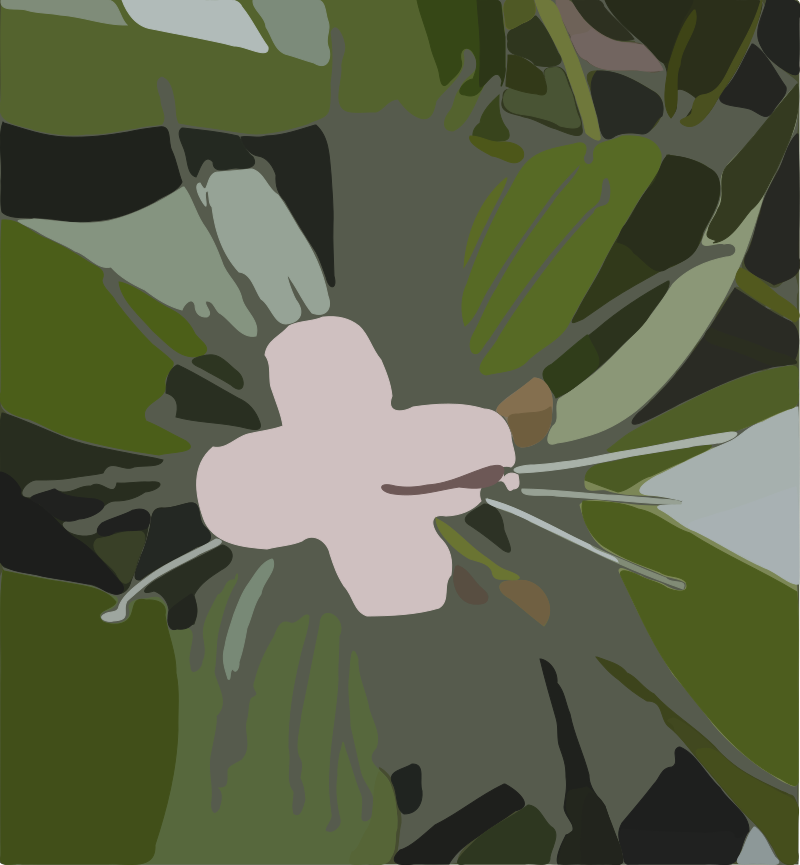

Topic5\flower.jpg vs SVG2PNG_Topic5\flower.png: 80.45423988439306
Topic5\hot-air-balloon.jpg 
use_bezier_curve_num : 1000 
component_num : 98


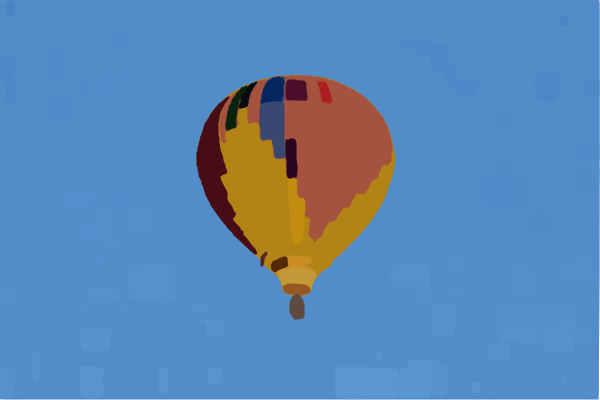

Topic5\hot-air-balloon.jpg vs SVG2PNG_Topic5\hot-air-balloon.png: 27.03309861111111
Topic5\autumn_01.png 
use_bezier_curve_num : 1000 
component_num : 22


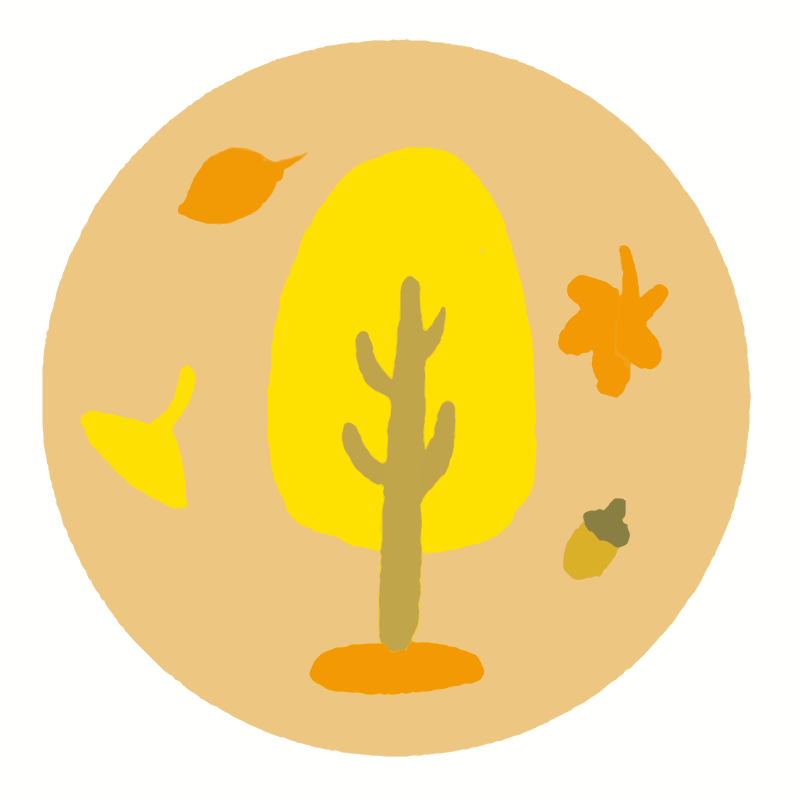

Topic5\autumn_01.png vs SVG2PNG_Topic5\autumn_01.png: 2.1081286458333333
Topic5\dolphin.png 
use_bezier_curve_num : 1000 
component_num : 78


C:\Users\a5658\AppData\Local\Temp\ipykernel_19356\2924573033.py:200: RuntimeWarning: invalid value encountered in divide
  sorted_masks[i]["color"] = np.sum(image * np.expand_dims(tm,2),(0,1))/np.sum(tm)


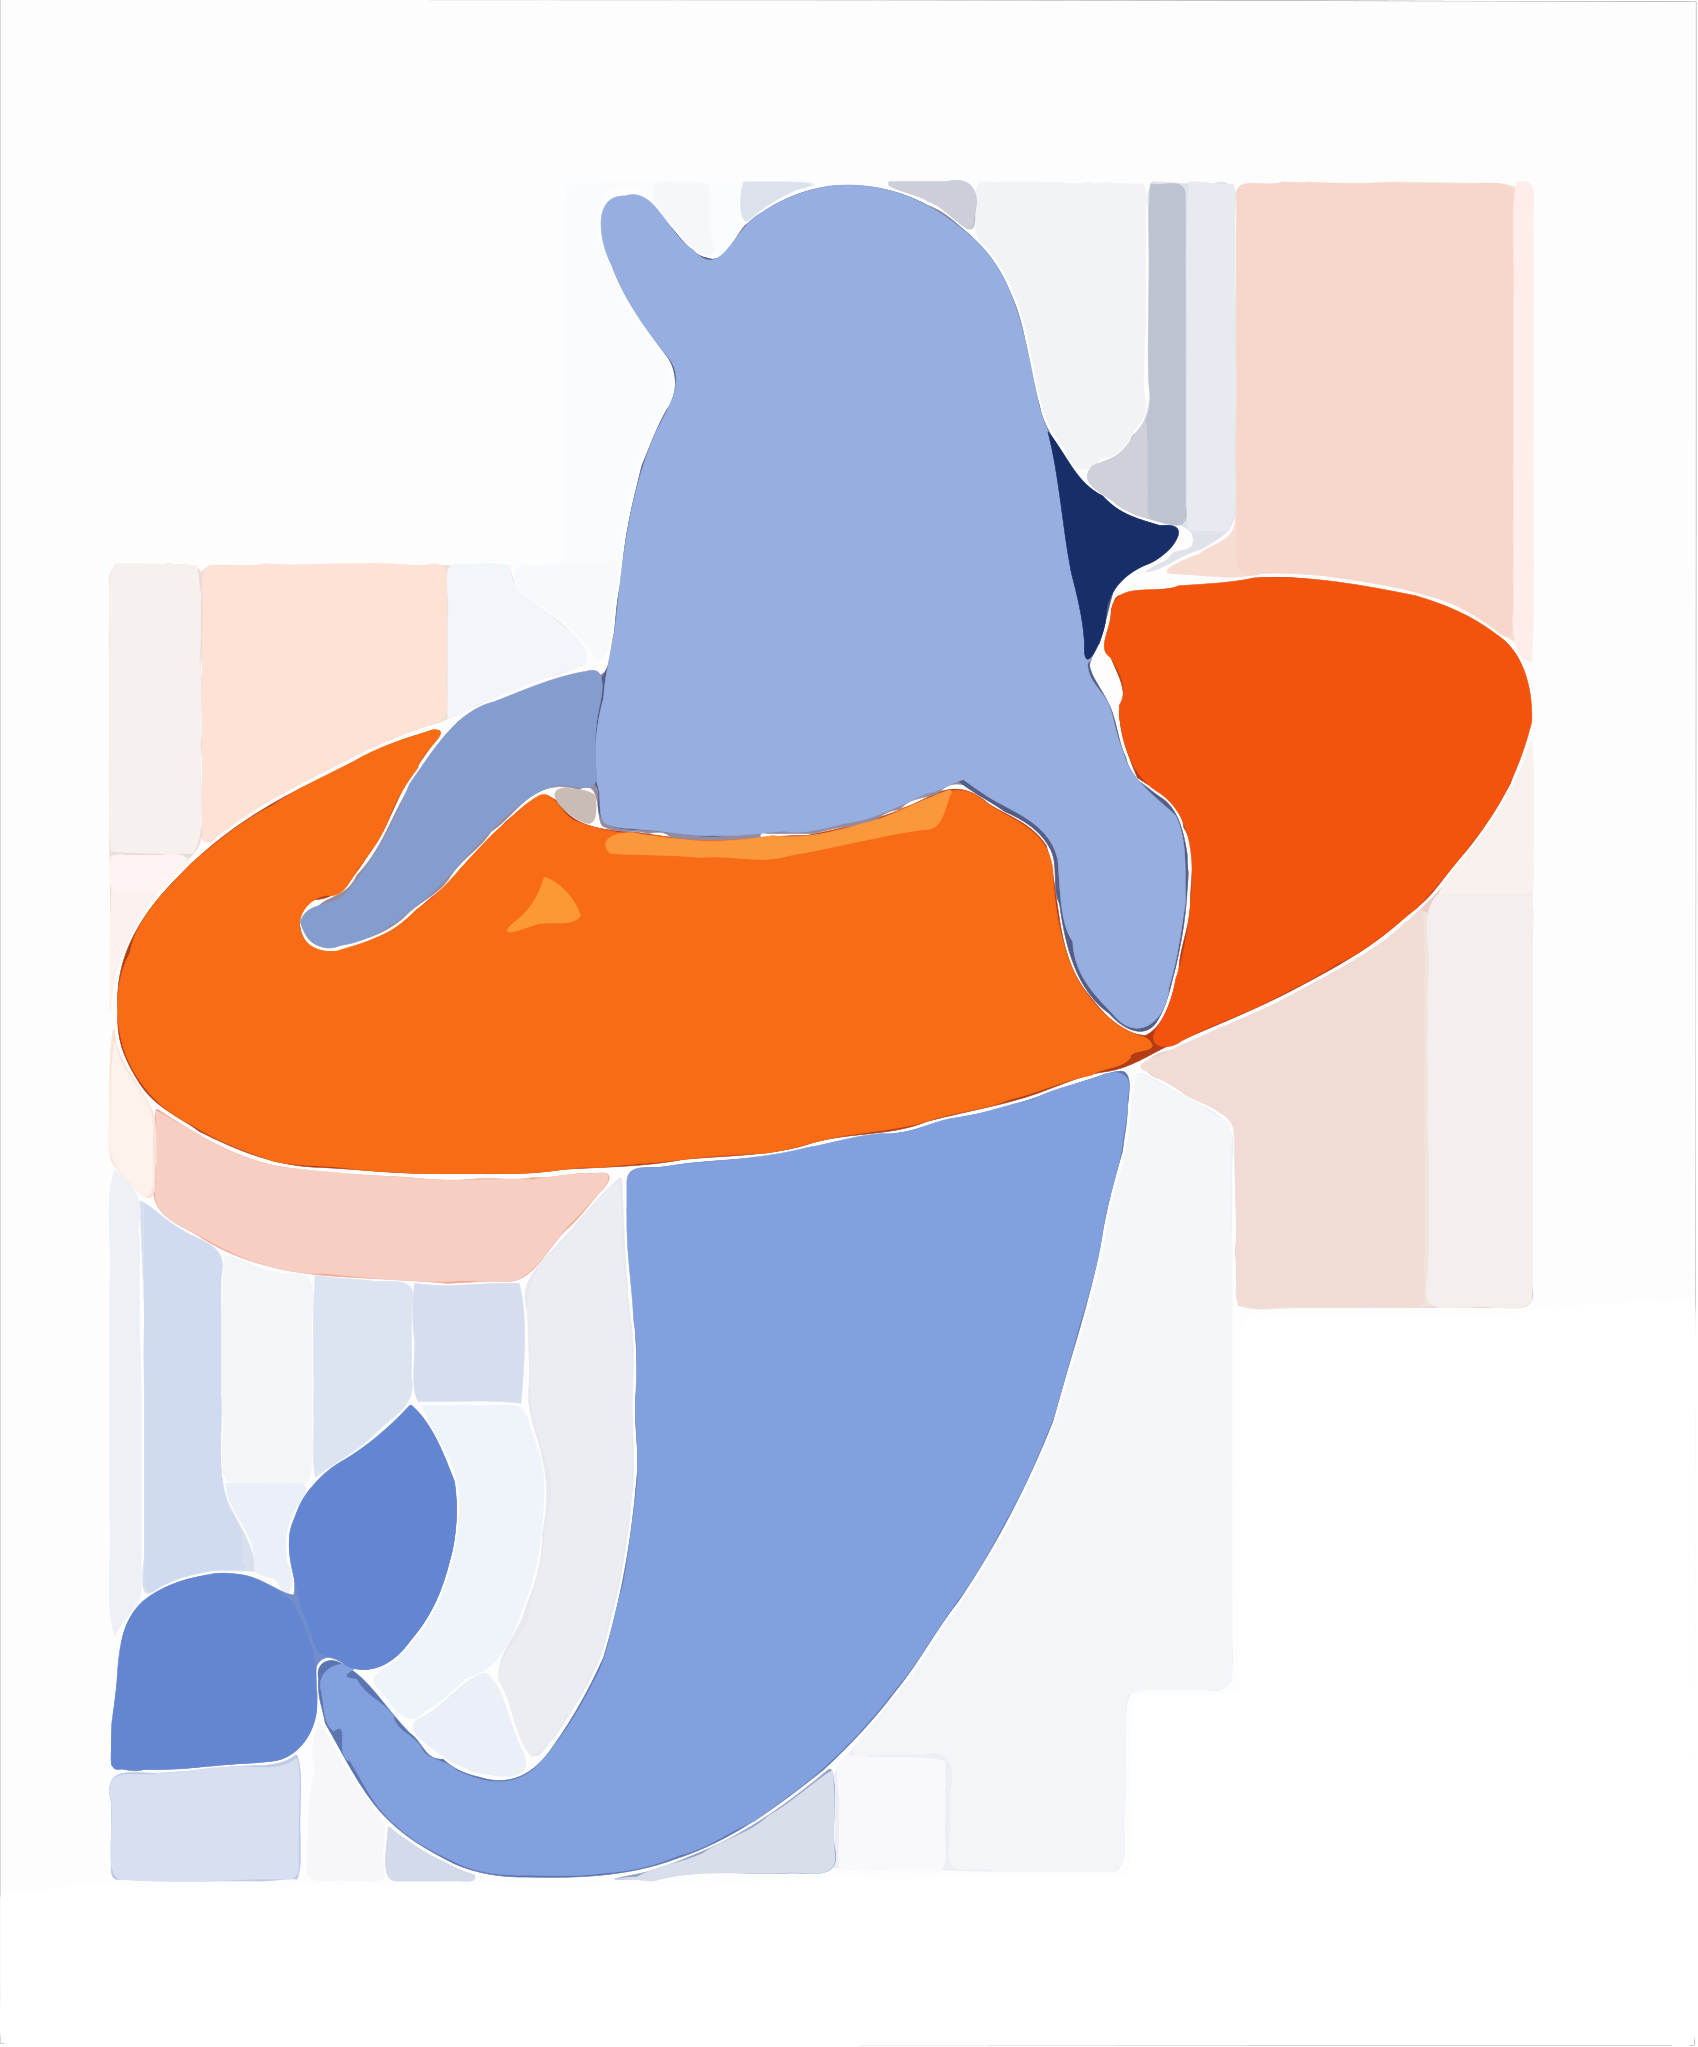

Topic5\dolphin.png vs SVG2PNG_Topic5\dolphin.png: 46.226434265502405
Topic5\house.png 
use_bezier_curve_num : 1000 
component_num : 57


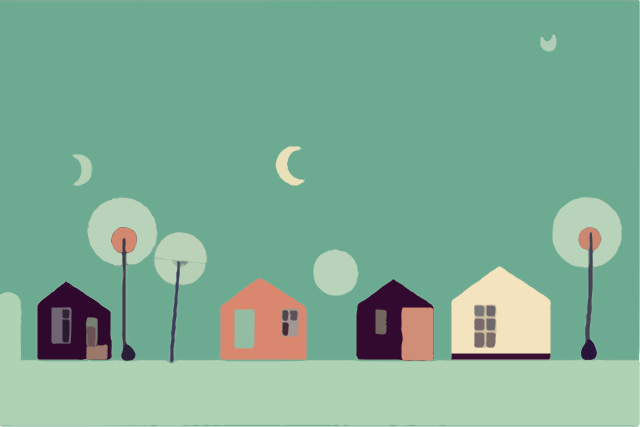

Topic5\house.png vs SVG2PNG_Topic5\house.png: 6.786181450039032
Topic5\meditation.png 
use_bezier_curve_num : 1000 
component_num : 60


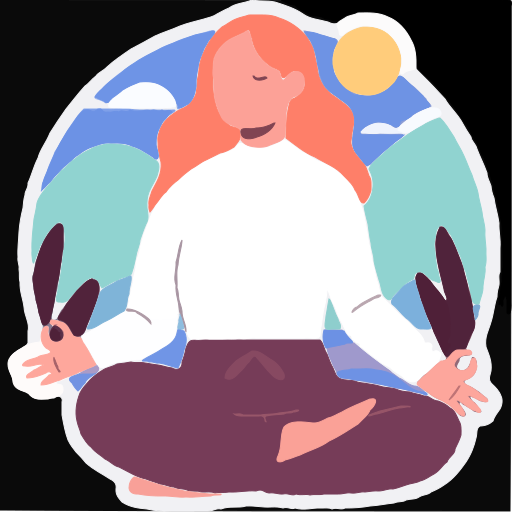

Topic5\meditation.png vs SVG2PNG_Topic5\meditation.png: 34.96741612752279
Topic5\tree.png 
use_bezier_curve_num : 1000 
component_num : 100


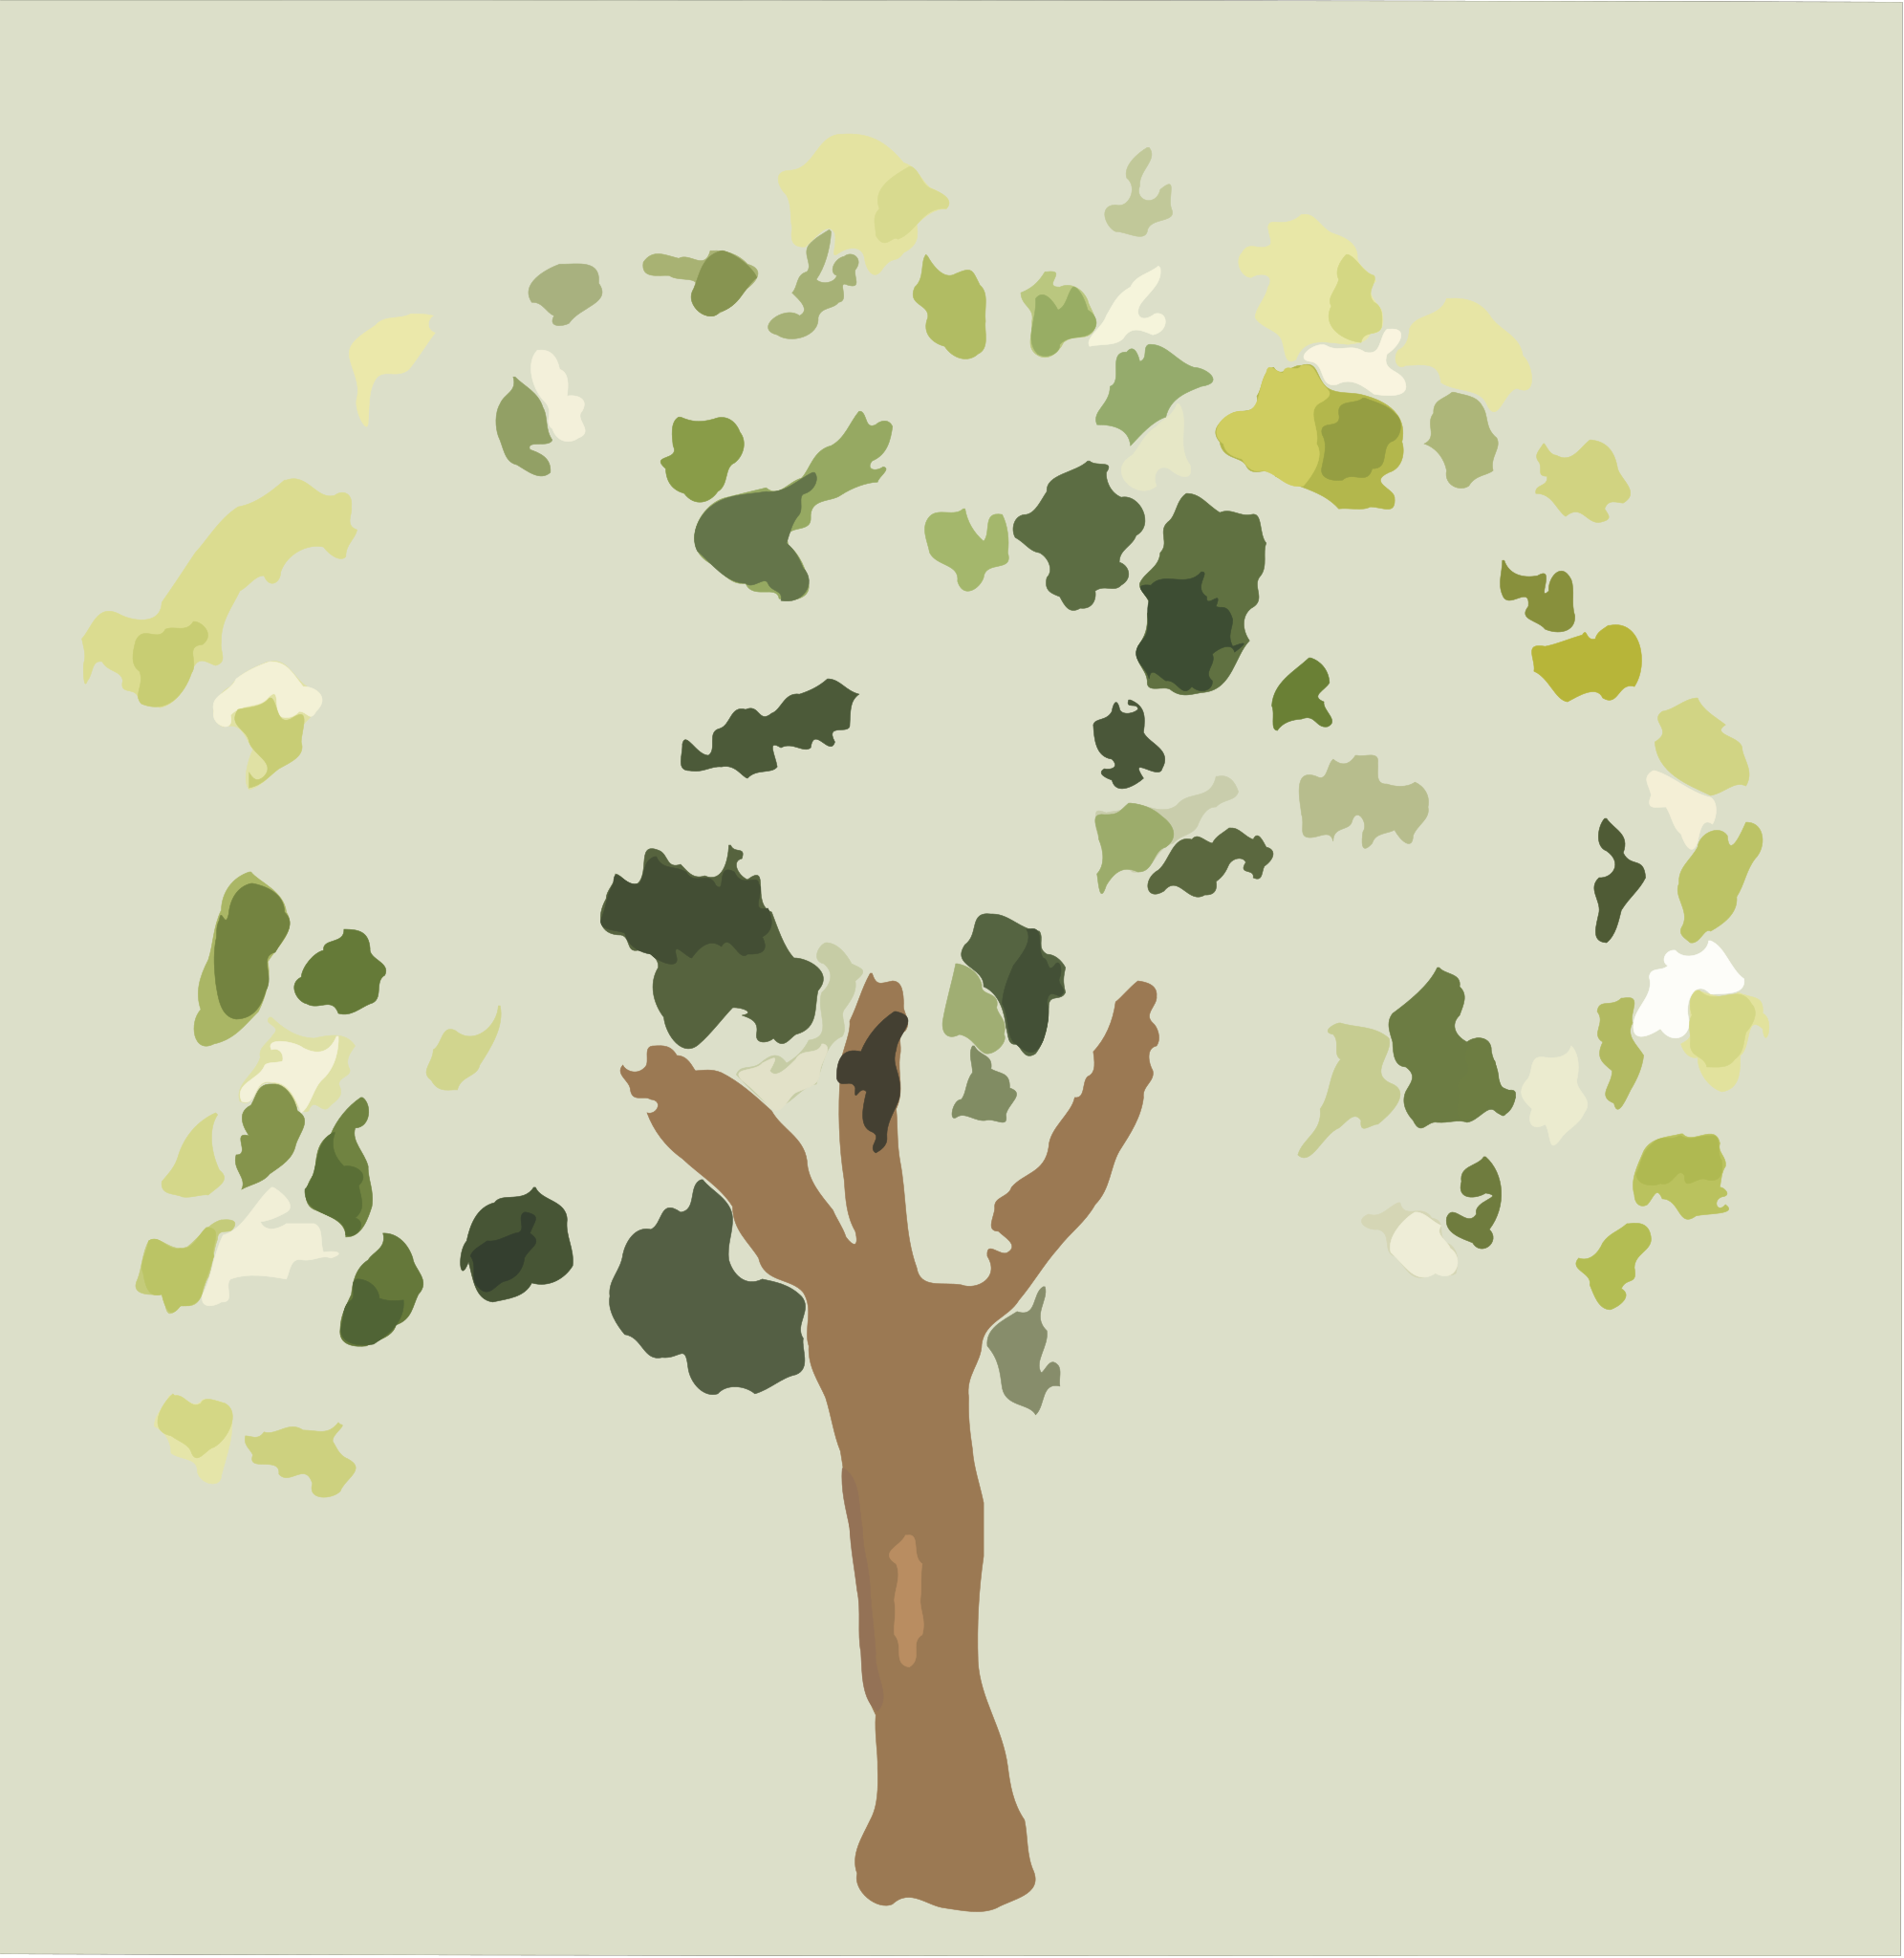

Topic5\tree.png vs SVG2PNG_Topic5\tree.png: 94.53035116102392
Topic5\work-from-home.png 
use_bezier_curve_num : 1000 
component_num : 42


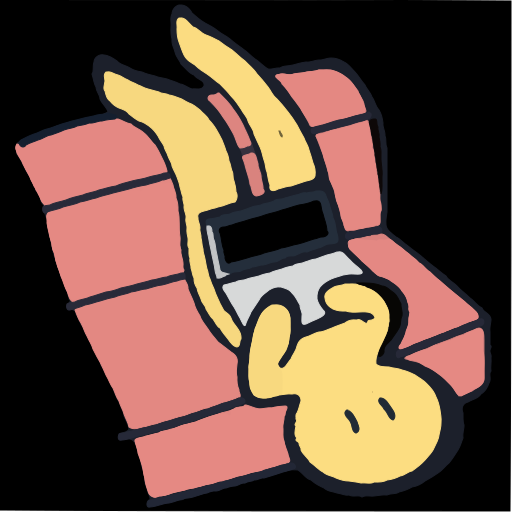

Topic5\work-from-home.png vs SVG2PNG_Topic5\work-from-home.png: 13.08600107828776
Topic5 Total MSE: 402.95144120110837


In [17]:
max_component_num = 100
max_bezier_curve_num = 1000

image_floder = 'Topic5'

import os

gtkbin = r'C:\Program Files\GTK3-Runtime Win64\bin'
add_dll_dir = getattr(os, 'add_dll_directory', None)
if callable(add_dll_dir):
    add_dll_dir(gtkbin)
else:
    os.environ['PATH'] = os.pathsep.join((gtkbin, os.environ['PATH']))

import glob
import random
from cairosvg import svg2png
from IPython.display import display, SVG


image_paths=glob.glob(image_floder+"/*.jpg")+glob.glob(image_floder+"/*.png")
# random.shuffle(image_paths)
tmse=0

for image_path in image_paths:
    SAMVGV1(image_path,max_component_num,max_bezier_curve_num,V21=False,V31=False)

    #convert SVG to PNG
    svg_path = 'SVG_' + image_path.split('.')[0]+'.svg'
    write_path = 'SVG2PNG_' + image_path.split('.')[0] + '.png'
    # Display an SVG file directly from its path
    display(SVG(filename=svg_path))
    svg2png(url=svg_path, write_to=write_path, unsafe=True)
    mse=calculate_mse(image_path, write_path)
    tmse+=mse
    print(image_path +" vs " + write_path + ": " + str(mse))
print(image_floder+" Total MSE:",tmse)